# Tutorial - Benchmarking the role of particle statistis in Quantum Reservoir Computing

The main goal of this notebook is to familiarize you with Quantum Reservoir Computing (QRC). 

In this tutorial you will learn:
- What is QRC?
- How you can train a QRC to perform a machine learning task?
- Evaluate the performance for different particles.

This tutorial is based on the paper [_Benchmarking the role of particle statistics in Quantum Reservoir Computing_](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202200100).


In [1]:
# Run in Google Colab
!pip install benchmarking_qrc --quiet

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pathlib
from scipy.linalg import lstsq

import benchmarking_qrc as qrc
from benchmarking_qrc import run_memory_capacity as mc

ModuleNotFoundError: No module named 'benchmarking_qrc'

In [3]:
np.random.seed(1)

## Introduction - What is QRC?


Quantum Reservoir Computing (QRC) is based on a machine learning technique called Reservoir Computing (RC). RC is specially suited to solve temporal tasks (ex: historical power consumtion, annual temperatures, stock market) because it exploits the dynamics of a nonlinear system called reservoir. The intuition behind RC is to map an input into a high-dimensional space (reservoir) that facilittes the separtion of the initial data. After this mapping, the output layer is trained to extract valuable reservoir features and mathc the expected output.

There are other machine learning techniques like Recurrent Neural Networks, which its dynamics also exploits the fact that the information can remain stored in the network for a finite amount of time. This characteristic is often defined as memory, making RNN and RC suitable to process sequential data. However, RNN feedback loops (see Figure) can be extremely hard to train. In constrat, RC only train the weights in the output layer, which leads to an easy training and fast learning because backpropagation is not need to optimize weights.

<img src="./images/rnn_and_rc.png" alt="drawing"/>

As shown in the above Figure the architecture of RNN looks rather complex compare to RC with only three layers. To ensure a proper performance the reservoir must satisfy several requirements:  
- **Convergence** or **Echo State Property**: The result obtained in the output layer must be totally independent of the initial conditions of the reservoir.
- **Nonlinearity**: The reservoir must provide a nonlinear transformation with respect to the inputs. In this way, most of the computational cost can be outsourced to the reservoir while the output layer can be taken as a linear funtion, which its easier to train. 
- **Fading memory**: The dynamics in the reservoir is able to retain memory of present and past inputs, but it also able to dissipate the information for irrelevant inputs very far in the past.
- **Separability**: Different inputs sequence should produce different outputs.

All these features (complex dynamics and high-dimensional space) can be enhanced if we move to the field of Quantum Reservoir Computing (QRC). A major advantatge lies in the fact that quantum computers can store exponentially more information in the Hilbert space, where quantum particles reside, than classical computers. In addition, QRC is suitable for Noisy intermediate-scale quantum (NISQ) since it doesn't need perfect dynamics to perform computation. As shown, in the [seminal work](https://arxiv.org/abs/1602.08159) of Nakajima et. al, a QRC of 5-7 qubits exhibits similar performance to an echo state network (classical method) of 100-500 nodes.

The standard algorithm of RC/QRC can be explained in three steps as shown in the following Figure:
- **Input**: Injecting data into an ancilla particle, which is coupled to the reservoir. In this step, the low-dimensional input data is mapped into a high-dimensional dynamical system. 
- **Reservoir**: Let the reservoir evolve for a certain period of time following its natural dynamics. At each iteration, a new input will be injected driving the dynamics. 
- **Output**: Extract features from the reservoir using a set of observables. Then, a linear combination of all the features will be optimized to reproduce the desired target.

In the next section, we will introduce the mathematical formalism describing each step.

<img src="./images/QRC_diagram.png" alt="drawing"/>

Although different types of systems have been proposed as quantum reservoirs, the role of the statistics has not been established yet. In this work, we have assessed the ability of different particles (fermions, bosons and spins) to store information from past inputs. This has allowed us to find two key ingredients to take into account for future QRC projects. Firstly, fermions are better information carriers than spins due to the anticommutation rules. Secondly, under a tailored input injection strategy bosons can exploit the abundance of degrees of freedom in its Hilbert space and improve its ability to store information. For more details, check out the article in this [link](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202200100).

### The task

In this section, we will briefly introduce the machine learning task that the QRC is going to perform and the metric to quantify the results.

Our objective is to quantify the how well the quantum system can recover past information. So, we will inject a sequence of random inputs ($u_k$) into the reservoir and the system will be trained to match a target function

$$ \hat{y}_k = u_{k-\tau}$$

where $\tau$ is the delay between the input and target.

<div class="alert alert-block alert-info">
    <b>Example:</b>    
    
Given an input sequence:
$$ u = (0.2, 0.3, 0.4, 0.5) $$

The target function after a delay, $\tau=1$ is:

$$ \hat{y} = (0.1, 0.2, 0.3, 0.4) $$

But the reservoir after the training procedure may output a different result:

$$ y = (0.11, 0.19, 0.3, 0.398) $$
</div>

Let us introduce the metric to meause the system memory. The memory capacity is a standard measure of memory in recurrent neural network and is defined as:

$$ MC = \frac{Cov^2(y,\hat{y})}{\sigma^2(y)\sigma^2(\hat{y})} $$

where $\sigma(y)$ and $\sigma(\hat{y})$ are the standard deviation of the reservoir and target outputs, respectively. The $MC$ may look familiar to some readers because it is simply the Pearson correlation coefficient to the power 2. This implies that the MC is bounded between 0 (there is no correlation between $y$ and $\hat{y}$) and 1 (the system has been able to fully recover the target function).

## Hands-on approach - How to train a QRC 

In this section we explain the mathematical formalism to train a Quantum Reservoir with a fermionic reservoir of only two particles to visualize what the code is actually doing. Later on, we will increase the reservoir size up to 4 fermions. The following table summarizes all the equations that we are going to introduce:

<img src="../notebooks/images/rnn_and_rc.png" alt="drawing"/>


### Step 0: Setting up the system

The first step is to define the reservoir initial conditions, namely define a the initial state of a quantum many-body system. In this case the reservoir is build with 2 fermions in the ground state $\lvert 0 \rangle$ using the function `initial_state`. Since fermions are a two-level systems ($\lvert 0 \rangle$, $\lvert 1 \rangle$) the Hilbert dimensions of fermions is always 2 (`dim_fermion=2`).

In [2]:
# initial parameters
n_fermions = 2
dim_fermion = 2

initial_reservoir = qrc.reservoir.initial_state(n_fermions, dim_fermion)
initial_reservoir

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

To process information particles must interact with each other. The interaction strenght between particles $i$ and $j$ is defined by the parameter $J_{ij}$ and the natural dynamics of the system is ruled by the following quadratic Hamiltonian

$$ H = \sum_{i,j=1}^{N}J_{ij}a_{i}^{\dagger}a_{j} $$

This Hamiltonian encodes the onsite interation ($J_{ii}$) and the coupling iterations ($J_{ij}$) among all particles.


In [3]:
# Generates random values between [0, 1)
J_ij = qrc.hamiltonian.get_coefficients(n_fermions, coef_range=[0, 1], seed=1) 

fermionic_hamiltonian = qrc.hamiltonian.quadratic_op(n_fermions, is_bosonic=False, dimensions=dim_fermion, coefficients=J_ij)

np.around(fermionic_hamiltonian.todense(), 2)

matrix([[0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
        [0.  +0.j, 0.72+0.j, 0.  +0.j, 0.  +0.j],
        [0.  +0.j, 0.  +0.j, 0.42+0.j, 0.  +0.j],
        [0.  +0.j, 0.  +0.j, 0.  +0.j, 1.14+0.j]])

As a last ingredient to simulate the dynamics of the reservoir, we need the evolution operator ($e^{-iH\Delta t}$) to compute the next state of reservoir ($\rho(t)$). 

$$ \rho(t_f) = e^{-iH\Delta t}\rho(t_i)e^{iH\Delta t}$$

The $\Delta t$ quantifies how much time we let system evolve. By default, $\Delta t = 10$ because we want that the injected information in the system is spread through the whole system.

In [4]:
fermionic_evolution = qrc.hamiltonian.get_evolution_op(fermionic_hamiltonian, dt=10)
np.around(fermionic_evolution, 2)

array([[ 1.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ],
       [ 0.  +0.j  ,  0.61-0.8j ,  0.  -0.j  ,  0.  +0.j  ],
       [ 0.  +0.j  ,  0.  -0.j  , -0.52+0.86j,  0.  +0.j  ],
       [ 0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.37+0.93j]])

### Step 1: Echo state property (wash out)

To avoid any possible effect of the initial conditions of the reservoir we always start with the wash out step before training the system. This step consists in injecting a set of inputs until the initial conditions become irrelevant. The amount of iterations needed to wash out the initial conditions can be found in Figure 2 of the paper.

To encode classical data ($u_k$) into a quantum state ($\lvert \psi \rangle$) we can use `get_input_state`.

$$ \lvert \psi_k^{(e=1)} \rangle = \sqrt{u_k}\lvert 0 \rangle + \sqrt{1-u_k}\lvert 1 \rangle$$

For fermions we need to inject 3000 inputs to erase the initial conditions according to the Figure 2. However, it is possible that for certain values of $J_{ij}$ the numbers of iterations required is lower. Notice that for fermions the excited level is obvioulsy $\lvert 1 \rangle$, but for bosons the excited level could be $\lvert 1 \rangle$, $\lvert 2 \rangle$ ... $\lvert n \rangle$.

In [5]:
wash_time = 3000
wash_out_signals = np.random.uniform(low=0, high=1, size=wash_time)

# Generating the first input state
excited_state=1
input_state = qrc.reservoir.get_input_state(wash_out_signals[0], dim_fermion, excited_state)
input_state

array([[0.54984777],
       [0.83526488]])

Then, we can inject this quantum state into the first particle of the reservoir with `insert_input`. This function computes the tensor product between the input state, $\rho_{1, k}^{(e)}=\lvert \psi_k^{(e)} \rangle \langle \psi_k^{(e)} \lvert$, and all particles of the reservoir except the first one, ${\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\}$

$$ \rho(k\Delta t)= \rho_{1, k}^{(e)} \otimes {\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\} $$

In [6]:
reservoir_with_input = qrc.reservoir.insert_input(input_state, initial_reservoir)
reservoir_with_input

array([[0.30233257, 0.        , 0.45926854, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.45926854, 0.        , 0.69766743, 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

To let the information spread through the whole system we let the system evolve following the quantum dynamics of a closed system, as shown in the table above.


$$ \rho\left(k\Delta t\right)=e^{-iH\Delta t}\left[\rho_{1,k}^{(e)}\otimes {\rm Tr}_{1}\left\{ \rho\left(\left(k-1\right)\Delta t\right)\right\} \right]e^{iH\Delta t} $$

In [7]:
reservoir = qrc.reservoir.evolve(reservoir_with_input, fermionic_evolution)

So, at each iteration the reservoir will change following these 3 steps:
- Encoding classical data into a quantum state $\Longrightarrow \lvert \psi_k^{(e)} \rangle$.
- Injecting the quantum state into the reservoir $\Longrightarrow \rho(k)$.
- Evolving the reservoir $\Longrightarrow  \rho(k\Delta t)$.

To avoid calling the previous three functions at each iteration, we have packed the previous 3 points in a single function call `cptp_map` which will generate a reservoir state for each injected input. 

In [8]:
# Generates a list with the state of the reservoir after each iteration
reservoirs = list(qrc.reservoir.cptp_map(wash_out_signals, initial_reservoir, fermionic_evolution, dim_fermion, excited_state))

# Take the last reservoir from the previous list
washed_reservoir = reservoirs[-1]
np.around(washed_reservoir, 3)

array([[ 0.191+0.j   , -0.   +0.j   , -0.203-0.337j,  0.   +0.001j],
       [-0.   -0.j   ,  0.   +0.j   ,  0.   +0.001j, -0.   -0.j   ],
       [-0.203+0.337j,  0.   -0.001j,  0.808+0.j   , -0.002-0.001j],
       [ 0.   -0.001j, -0.   +0.j   , -0.002+0.001j,  0.   +0.j   ]])

### Step 2: Data prepartion

Once we have a `washed_reservoir` you can start training the reservoir to perform any typical supervise machine learning task. In a real world scenario you will have a dataset with a time-series (ex: temperatures over several years, stock market, etc.).

In our case, we are interested in benchmarking the ability to store past inputs, so a random sequence of number is good enough for our porpuses. Let's start by setting some parameters, as the `delay`, `train_time` and `test_time`.
- `delay`: Number of iterations between the input and target data. As the delay increase, it will become harder to remember the input.
- `train_time` and `test_time`: Number of iterations to train/test the reservoir.

Then, instead of uploading a dataset we will simply generate random numbers. 
_Remember that we have already set a seed for generating the coefficients $J_{ij}$, so the following results are totally reproducible_.



In [9]:
delay = 1
train_time, test_time = 10, 10

# Prepare random data
train_signals = np.random.uniform(low=0, high=1, size=train_time + delay)
test_signals = np.random.uniform(low=0, high=1, size=test_time + delay)

Let's also prepare the input with the function `get_inputs`.

In [10]:
# Generating inputs to train and test the reservoir.
train_inputs = mc.get_inputs(train_signals, delay)
test_inputs = mc.get_inputs(test_signals, delay)
inputs = np.concatenate((train_inputs, test_inputs))
print("inputs =", np.around(inputs, 2))

inputs = [0.96 0.56 0.65 0.27 0.95 0.67 0.67 0.01 0.85 0.78 0.74 0.16 0.72 0.1
 0.71 0.   0.78 0.49 0.2  0.73]


As well, the function `get_targets` generates the target for linear task when $\hat{y}=u_k$ and for the non-linear task $\hat{y}=u_k^q$ ($q \neq 1$).

In [11]:
# Generating targets
train_targets = mc.get_targets(train_signals, delay, degree=1)
test_targets = mc.get_targets(test_signals, delay, degree=1)
print("train_targets =", np.around(train_targets, 2))

train_targets = [0.98 0.96 0.56 0.65 0.27 0.95 0.67 0.67 0.01 0.85]


### Step 3: Enconding data into a high dimensional space

The following line it should look familiar:

In [12]:
reservoirs = list(qrc.reservoir.cptp_map(inputs, washed_reservoir, fermionic_evolution, dim_fermion, excited_state))

Exactly, this function is used to generate a sequence of reservoir states (just as in the wash out step). The imporant thing to remember is that each of these reservoir states contain some information from the past inputs. 

Now, we would like to extract some information ($x_j$) from the quantum system by performing some measurements.   

$$ x_{j}\left(k\Delta t\right)={\rm Tr}\left[O_{j}\rho\left(u_k\Delta t\right)\right]   \qquad  (1)$$

To do that, we need to define a set of observables. For this tutorial we will use observables of the form $a_i^\dagger a_j$. 

In [13]:
obs = qrc.measurements.observables("fermion", n_fermions, dim_fermion, "ij")

In the following you can notice that `obs` is a list that contain the diagonal a non-diagonal observables:

- $a_0^\dagger a_0$
- $a_1^\dagger a_1$
- $a_0^{\dagger}a_1 + a_1^{\dagger}a_0$

In [14]:
# diagonal observable: adag_0 a_0
print(obs[0])

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [15]:
# diagonal observable: adag_1 a_1 
print(obs[2])

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [16]:
# non-diagonal observable: adag_0 a_1 + adag_1 a_0
print(obs[1])

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


Typically, conventional neural networks (NN) algorithms use a nonlinear function ($f$) like the ReLU or sigmoid to fit the input data ($x$)

$$y_{NN}=f(\rm{wx}+\rm{b})$$

where $y$ is the output of the NN and $w$, $b$ is the weights and bias that the network will optimize to fit the target data.  

With the reservoir computing (RC) framework such a nonlinear function is already introduce in the dynamics of the reservoir. Hence, optimizing the weights becomes an easy task, since they can be found using a linear regression algorithm. 

$$ y_{RC}=\rm{wx}+\rm{b}$$

In our case, we have a output ($y_k$) for each input value ($u_k$). So our linear equation is of the form  

$$ y_k = \sum_{j=1}^M \rm{x_{kj}w_j}$$

This can be written in a vectorize notation as:

$$ y = XW$$

where $y=[y_1, y_2, ... y_k, ... y_L]$ are the predictions of the algorithm, $W=[w_1, w_2, ... w_j, ... w_M, b]$ are the weights and bias to be optimized and $X$ is matrix with shape (L, M+1).

$$X=\begin{bmatrix} {\rm Tr}\left[O_{1}\rho\left(u_1\Delta t\right)\right]  & {\rm Tr}\left[O_{2}\rho\left(u_1\Delta t\right)\right] & .. & {\rm Tr}\left[O_{M}\rho\left(u_1\Delta t\right)\right] & 1 \\
{\rm Tr}\left[O_{1}\rho\left(u_2\Delta t\right)\right]  & .. & .. & {\rm Tr}\left[O_{M}\rho\left(u_2\Delta t\right)\right] & 1\\ 
.. & .. & .. & .. & ..\\
{\rm Tr}\left[O_{1}\rho\left(u_L\Delta t\right)\right]  & .. & .. & {\rm Tr}\left[O_{M}\rho\left(u_L\Delta t\right)\right] & 1
\end{bmatrix}$$

To compute the previous matrix, you can use the `get_features` function.

In [17]:
dataset, _ = qrc.measurements.get_features(reservoirs, obs)

# Approximate dataset values up to 3 decimals
np.around(dataset, 3)

array([[ 0.039,  0.001,  0.001,  1.   ],
       [ 0.443,  0.   ,  0.001,  1.   ],
       [ 0.354, -0.002,  0.001,  1.   ],
       [ 0.728, -0.004,  0.001,  1.   ],
       [ 0.048, -0.001,  0.001,  1.   ],
       [ 0.33 ,  0.001,  0.001,  1.   ],
       [ 0.333,  0.002,  0.001,  1.   ],
       [ 0.989, -0.001,  0.001,  1.   ],
       [ 0.147,  0.   ,  0.001,  1.   ],
       [ 0.222, -0.002,  0.001,  1.   ],
       [ 0.259, -0.003,  0.001,  1.   ],
       [ 0.843, -0.002,  0.001,  1.   ],
       [ 0.281,  0.001,  0.001,  1.   ],
       [ 0.903,  0.   ,  0.001,  1.   ],
       [ 0.293,  0.002,  0.001,  1.   ],
       [ 0.997, -0.001,  0.001,  1.   ],
       [ 0.224, -0.002,  0.001,  1.   ],
       [ 0.508, -0.004,  0.001,  1.   ],
       [ 0.796, -0.002,  0.001,  1.   ],
       [ 0.271,  0.001,  0.001,  1.   ]])

### Step 4: Optimizing weights

The optimal weights are computing minimizing the 2-norm error between the target values $\hat{y}$ and the actual predictions $y=XW$ 

$$ arg\min_{W} |\hat{y}-XW|.$$

In the well-known package `scipy` there is a specific function to optimize linear regression problems called `lstsq`. But before we split the dataset into train and test to later evaluate the results and check if the parameters used overfit the data.

In [18]:
train_X = dataset[:train_time, :]
test_X = dataset[train_time:, :]

# Getting optimal weights
opt_weights, _, _, _ = lstsq(train_X, train_targets)

print(f"optimal weights={np.around(opt_weights, 3)}")

optimal weights=[ 2.3400000e-01  2.1895000e+01 -4.8755787e+04  2.8595000e+01]


### Step 5: Evaluating the memory capacity

The memory capacity ($MC$) is a metric that quantifies the linear correlation between two vectors. If both vectors are identical $MC=1$, if there is no linear correlation $MC=0$.

$$MC=\frac{Cov^2(\hat{y}, y)}{\sigma^2(\hat{y})\sigma^2(y)} $$

The algorithm predictions with the best weights are:
$$ y_{train}^{\, p}=X_{train}w_{opt}$$

In [19]:
train_predictions = np.matmul(train_X, opt_weights)
print("train predictions=", np.around(train_predictions, 3))

train predictions= [0.701 0.798 0.656 0.601 0.479 0.605 0.733 0.809 0.641 0.543]


We can also compute the predictions on the test dataset `test_X`. 
$$ y_{pred}^{test} = X_{test}w_{opt}$$

In [20]:
test_predictions = np.matmul(test_X, opt_weights)
print("test predictions=", np.around(test_predictions, 3))

test predictions= [0.436 0.531 0.508 0.688 0.649 0.713 0.442 0.362 0.409 0.404]


Finally, we can measure the memory capacity.

In [21]:
train_mc = mc.memory_capacity(train_predictions, train_targets)
print(f"Train MC={np.around(train_mc, 3)}")

Train MC=0.113


In [22]:
test_mc = mc.memory_capacity(test_predictions, test_targets)
print(f"Test MC={np.around(test_mc, 3)}")

Test MC=0.015


Cleary, this results by no means great. The memory capacity is quite low and the algorithm is overfitting the data. To get good results the hyperparameters that must be optimized are:

- Number of particles 
- Training data
- $\Delta t$.

The Hamiltonian coefficients $J_{ij}$ also play an important role on how the informtion is spread through the system and it will be the next topic we are going to explore.


### Summary

In this tutorial, you have learnt how to train a QRC to perform a supervise task. 

If you want to play around (try different reservoir sizes, particles, train times, etc) we have introudce all the steps shown above in a function called `main`. So, there is no need to re-run previous cells, just set the parameters you are curios about and find out if the performance is improved or not.

In [23]:
# Parameters for fermions 

# Reservoir parameters
n_particles = 4 # 2, 3, .., n
dimensions = 2
J_ij = qrc.hamiltonian.get_coefficients(n_particles, coef_range=[0, 1], seed=1) # try different seeds
operator = "fermion"
excited_state = 1
dt= 10

# Performance parameters
delay = 1 # 1, 2, .., n
obs_form = "ij"
wash_time = 3000
train_time = 1200
test_time = 300


In [24]:
_, _, train_mc, test_mc = mc.main(
    n_particles,
    dimensions,
    J_ij,
    operator,
    delay,
    obs_form,
    wash_time,
    train_time,
    test_time,
    excited_state,
    dt
)

print(f"Reservoir with {n_particles} {operator}s:")
print(f"\tTrain MC={np.around(train_mc, 3)}")
print(f"\tTest  MC={np.around(test_mc, 3)}")

Reservoir with 4 fermions:
	Train MC=0.809
	Test  MC=0.808


To see the perfomance of spins write `operator="spin"`.  _Remember that as shown in the Figure 2 of the paper the wash time for spins is lower than for fermions_.

In [25]:
# Spin parameters
operator = "spin"
wash_time = 1000

_, _, train_mc, test_mc = mc.main(
    n_particles,
    dimensions,
    J_ij,
    operator,
    delay,
    obs_form,
    wash_time,
    train_time,
    test_time,
    excited_state,
    dt
)

print(f"Reservoir with {n_particles} {operator}s:")
print(f"\tTrain MC={np.around(train_mc, 3)}")
print(f"\tTest  MC={np.around(test_mc, 3)}")

Reservoir with 4 spins:
	Train MC=0.832
	Test  MC=0.852


In particular, for this configuration of parameters spins perform better than fermions. But as shown in our paper fermions will in general have better perfomance than spins. In the last section, of the tutorial we reproduce the Figure 3, in which its shown that fermions outperform spins.

## Extra: Bosonic reservoir

The main goal of the tutorial was to explain how QRC work. So, in the previous section we explained the basic componets of this machine learning framework using fermions. In this section, there isn't any new concept related to QRC, we will only explain a few key parameters to build a bosonic reservoir.

For bosons, there are two new hyperparameters that we can modify: 
- `dimensions`: For fermions/spins the Hilbert space only have 2 dimensions, but for bosons there are infinite dimensions.
- `excited_state`: For bosons we are no restricted to inject information only onto $\lvert 0 \rangle$ or $\lvert 1 \rangle$. 

As discussed in the paper to exploit the huge Hilbert space of bosons the input injection must excite high energy levels to get an optimal performance. Using `excited_state=2`the input injection would be of the form:

$$ \lvert \psi_k^{(e=2)} \rangle = \sqrt{u_k}\lvert 0 \rangle + \sqrt{1-u_k}\lvert 2 \rangle$$

As a drawback (at least for the simulation point of view, not experimentally), as the `excited_state` increases, so it does the number of `dimensions`. As it is shown in Figure 1 for an `excited_state=2` (`excited_state=1`) bosons must have at least `dimensions=6` (`dimensions=5`), in other words 6 (5) energy levels. 

_If for instance you use `excited_state=2` and `dimensions=3` the particles in the reservoir will be a poor approximation to the actual bosons_.

In [32]:
# Boson parameters
# This cell can take a few minutes to show the results. And even more if `dimensions=6` and `excited_state=2
operator = "boson"
dimensions = 5
excited_state = 1


_, _, train_mc, test_mc = mc.main(
    n_particles,
    dimensions,
    J_ij,
    operator,
    delay,
    obs_form,
    wash_time,
    train_time,
    test_time,
    excited_state,
    dt
)

print(f"Reservoir with {n_particles} {operator}s:")
print(f"\tTrain MC={np.around(train_mc, 3)}")
print(f"\tTest  MC={np.around(test_mc, 3)}")

Reservoir with 4 bosons:
	Train MC=0.608
	Test  MC=0.631


## Extra: Reproducing Fig. 3


Previous results are not statistical relevant since the performance is based one only one realization of $J_{ij}$.  However, it can be a bit time-consuming to run these code from `seed=1`to `seed=1000` to reproduce exactly the same results as in Figure 3. For this reason, we have shared this information in the `data` folder. Now, we will simple upload and plot the results of Figure 3.



In [26]:
def get_path(foldername, test_data):
    """Generates the path to train or test data location"""
    REPO = pathlib.Path().cwd().parent
    data = "test" if test_data else "train"
     
    return REPO / "data" / "memory_capacity" / foldername / data

def upload_data(foldername, test_data=True):
    """Upload the memory capacity for differents seeds between 1 and 1000"""
    data_path = get_path(foldername, test_data)
    return np.load(str(data_path / "range_1_1000.npy"))

def rename_folder(foldername, delay):
    """It changes the delay value from the foldername configuration"""
    split_str = foldername.split("_")
    split_str[3]=str(delay)
    return "_".join(split_str)

def plot(x, y, fmt, color, error_bars=None):
    if not isinstance(error_bars, type(None)):
        error = np.abs(error_bars-y)
    
    tick, _, _ = plt.errorbar(x, y, yerr=error, fmt=fmt, color="black", ecolor="black",
                 elinewidth=1, markersize=9, markerfacecolor="black", markeredgecolor="black")
    plt.fill_between(x, error_bars[0], error_bars[1], alpha=0.6, color=color)
    plt.grid()
    background = mpatches.Patch(color=color, alpha=0.6)
    return tick, background

In [27]:
# Parameters (change the foldername to upload spin or boson data)
delays = [1, 2, 3, 4, 5, 6, 7, 8]
foldername = "4_2_fermion_1_ij_3000_1200_300_1_10.0_1_0.0_uniform_(0.0, 1.0)"
test_data = True

quantiles_1, quantiles_2, quantiles_3 = np.zeros(len(delays)), np.zeros(len(delays)), np.zeros(len(delays))
for idx, delay in enumerate(delays):
    # Compute the quantile for memory capacities with different delays
    foldername = rename_folder(foldername, delay)
    test_mc = upload_data(foldername, test_data)
    q1, q2, q3 = np.quantile(test_mc, [0.25, 0.5, 0.75])
    
    # Store data into the quantiles arrays
    quantiles_1[idx] = q1
    quantiles_2[idx] = q2
    quantiles_3[idx] = q3

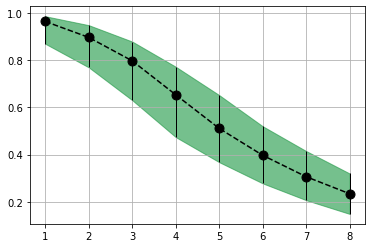

In [28]:
# Plot data
tick, background = plot(
    delays,
    quantiles_2, 
    fmt="o--",
    color="#1a9641",
    error_bars=np.array([quantiles_1, quantiles_3])
)